# Implementacion de la simulación

In [72]:
import heapq
import random
import numpy as np

def simulate(strategy, lambda1, lambda2, mu1, mu2, tk, sim_time):
    time = 0
    events = []


    if strategy == 'especializado':
        queues = [[], []]  # Colas separadas para pagos y cobros
        servers = [False, False]
        clients_in_system = [0, 0]  # Contadores independientes
        # Programar primeras llegadas
        heapq.heappush(events, (random.expovariate(lambda1), 'arrival', 0))
        heapq.heappush(events, (random.expovariate(lambda2), 'arrival', 1))
    else:
        queue = []          # Cola única compartida
        servers = [False, False]
        clients_in_system = 0
        heapq.heappush(events, (random.expovariate(lambda1 + lambda2), 'arrival'))

    # Estadísticas
    area_clients = 0.0
    prev_time = 0.0
    waiting_times = []
    server_busy = [0.0, 0.0]

    def update_stats(current_time):
        nonlocal prev_time, area_clients
        delta = current_time - prev_time
        if strategy == 'especializado':
            area_clients += (clients_in_system[0] + clients_in_system[1]) * delta
            for i in [0,1]:
                if servers[i]:
                    server_busy[i] += delta
        else:
            area_clients += clients_in_system * delta
            for i in [0,1]:
                if servers[i]:
                    server_busy[i] += delta
        prev_time = current_time

    while time < sim_time:
        event_time, event_type, *args = heapq.heappop(events)

        if event_time > sim_time:
            break

        update_stats(event_time)
        time = event_time

        if event_type == 'arrival':
            if strategy == 'especializado':
                queue_idx = args[0]
                arrival_time = time
                queues[queue_idx].append(arrival_time)
                clients_in_system[queue_idx] += 1  # Incremento correcto

                if not servers[queue_idx]:
                    servers[queue_idx] = True
                    # CORRECCIÓN CRÍTICA: Eliminar cliente de la cola al iniciar servicio
                    queues[queue_idx].pop(0)
                    service_time = random.expovariate(mu1 if queue_idx == 0 else mu2)
                    heapq.heappush(events, (time + service_time, 'departure', queue_idx))
                    waiting_times.append(0.0)

                # Programar próxima llegada
                next_arrival = time + random.expovariate(lambda1 if queue_idx == 0 else lambda2)
                heapq.heappush(events, (next_arrival, 'arrival', queue_idx))

            else:
                arrival_time = time
                queue.append(arrival_time)
                clients_in_system += 1

                # Asignar a servidor libre
                for i in [0,1]:
                    if not servers[i]:
                        servers[i] = True
                        service_time = random.expovariate(mu1)
                        heapq.heappush(events, (time + service_time, 'departure', i))
                        queue.pop(0)
                        waiting_times.append(0.0)
                        break

                # Programar próxima llegada
                next_arrival = time + random.expovariate(lambda1 + lambda2)
                heapq.heappush(events, (next_arrival, 'arrival'))

        elif event_type == 'departure':
            server_idx = args[0]

            if strategy == 'especializado':
                clients_in_system[server_idx] -= 1  # Decremento seguro
                if queues[server_idx]:
                    # Atender siguiente cliente
                    arrival_time = queues[server_idx].pop(0)
                    waiting_times.append(time - arrival_time)
                    service_time = random.expovariate(mu1 if server_idx == 0 else mu2)
                    heapq.heappush(events, (time + service_time, 'departure', server_idx))
                else:
                    servers[server_idx] = False
            else:
                clients_in_system -= 1
                if queue:
                    arrival_time = queue.pop(0)
                    waiting_times.append(time - arrival_time)
                    service_time = random.expovariate(mu1)
                    heapq.heappush(events, (time + service_time, 'departure', server_idx))
                else:
                    servers[server_idx] = False

    update_stats(sim_time)

    # Cálculo final de métricas
    avg_clients = area_clients / sim_time
    avg_wait = np.mean(waiting_times)*60 if waiting_times else 0.0
    p_crit = np.mean(np.array(waiting_times) > tk/60) if waiting_times else 0.0
    idle_time = 1 - sum(server_busy)/(2*sim_time)

    return {
        'avg_clients': avg_clients,
        'waiting_time': avg_wait,
        'p_over_tk': p_crit,
        'idle_time': idle_time
    }

# Comparación Servidores Especializados vs Generalistas

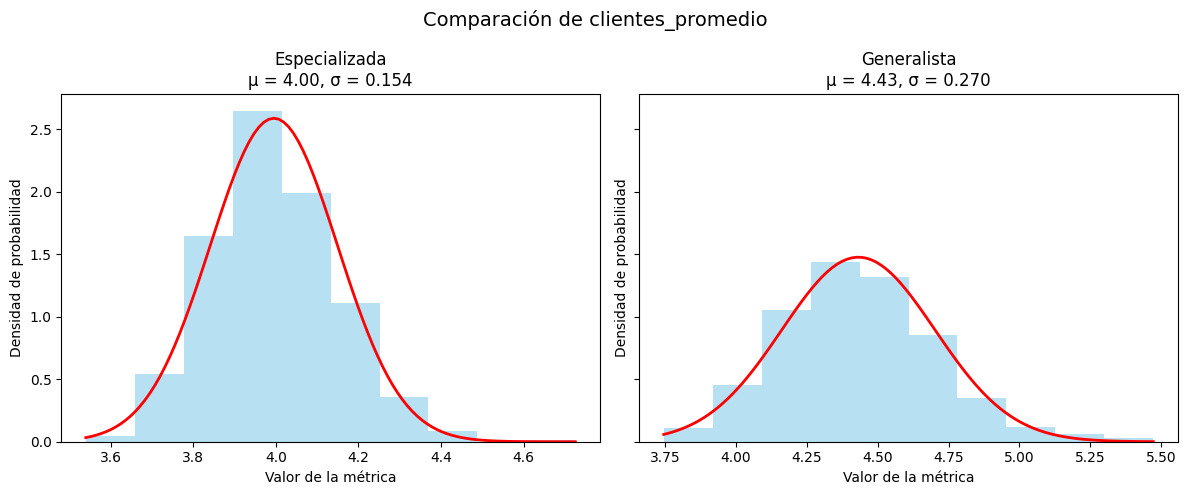

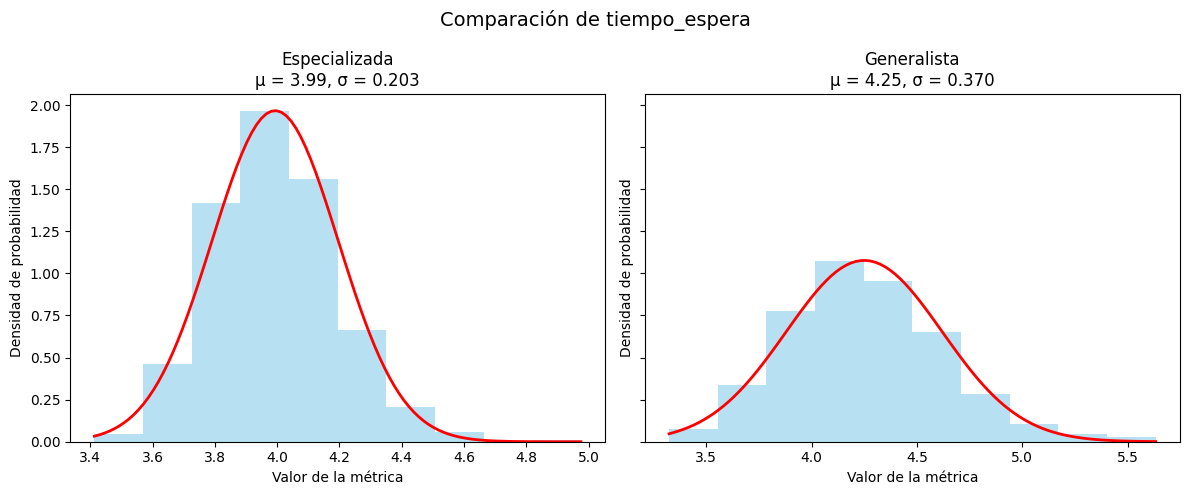

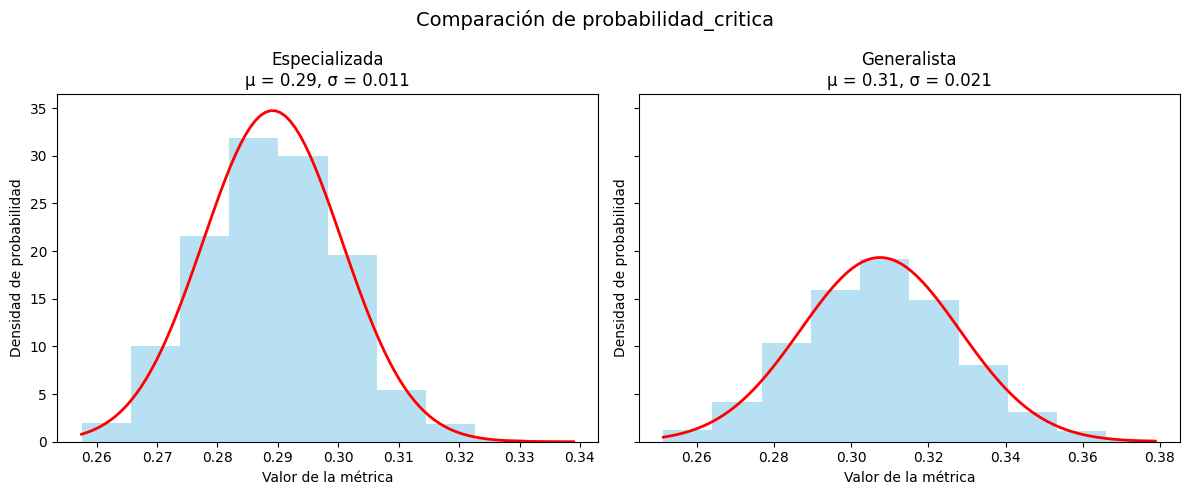

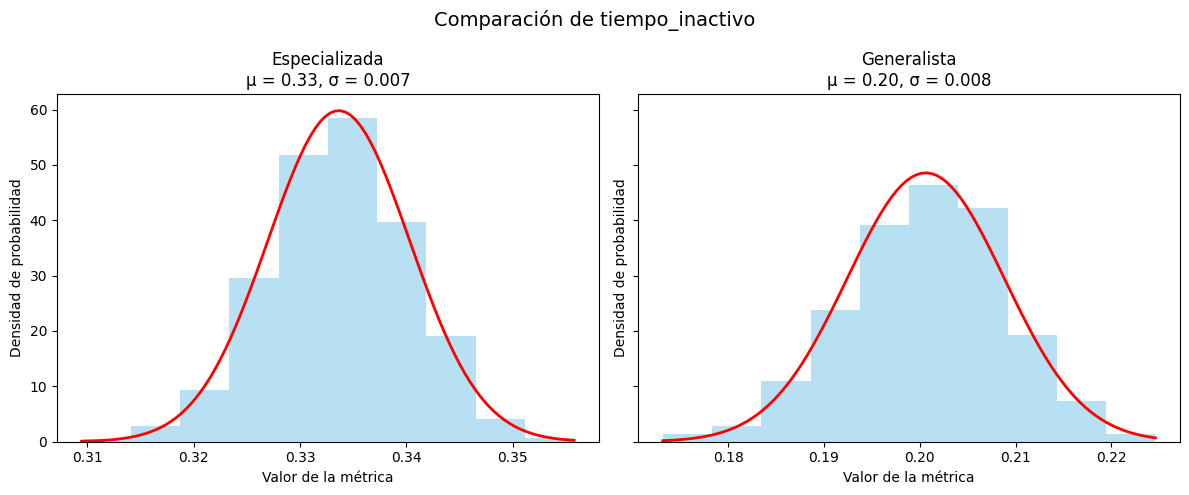

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def run_multiple_simulations(n_simulations, strategy, lambda1, lambda2, mu1, mu2, tk, sim_time):
    """
    Ejecuta múltiples simulaciones y recolecta métricas
    """
    metrics = {
        'avg_clients': [],
        'waiting_time': [],
        'p_over_tk': [],
        'idle_time': []
    }

    for _ in range(n_simulations):
        result = simulate(strategy, lambda1, lambda2, mu1, mu2, tk, sim_time)
        for key in metrics:
            metrics[key].append(result[key])

    return metrics

def plot_combined_metric(metric_name, data_esp, data_gen, bins=10):


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle(f'Comparación de {metric_name}', fontsize=14)

    # Configuración común
    hist_params = {
        'density': True,
        'color': 'lightblue',
        'edgecolor': 'navy',
        'alpha': 0.7
    }

    # Estrategia especializada
    mu_esp, sigma_esp = np.mean(data_esp), np.std(data_esp)
    ax1.hist(data_esp,bins=10,density=True,alpha=0.6,color='skyblue')
    x_esp = np.linspace(min(data_esp), max(data_esp), 100)
    ax1.plot(x_esp, norm.pdf(x_esp, mu_esp, sigma_esp), 'r-', linewidth=2)
    ax1.set_title(f'Especializada\nμ = {mu_esp:.2f}, σ = {sigma_esp:.3f}')

    # Estrategia generalista
    mu_gen, sigma_gen = np.mean(data_gen), np.std(data_gen)
    ax2.hist(data_gen, bins=10,density=True,alpha=0.6,color='skyblue')
    x_gen = np.linspace(min(data_gen), max(data_gen), 100)
    ax2.plot(x_gen, norm.pdf(x_gen, mu_gen, sigma_gen), 'r-', linewidth=2)
    ax2.set_title(f'Generalista\nμ = {mu_gen:.2f}, σ = {sigma_gen:.3f}')

    # Etiquetas comunes
    for ax in [ax1, ax2]:
        ax.set_xlabel('Valor de la métrica')
        ax.set_ylabel('Densidad de probabilidad')

    plt.tight_layout()
    plt.show()
    plt.close()


results_specialized = run_multiple_simulations(1000, "especializado", 20,20,30,30,5,480)
results_general = run_multiple_simulations(1000, "generalista", 20,20,25,25,5,480)

# Ejemplo de uso después de recolectar los datos
metricas = {
    'clientes_promedio': (results_specialized['avg_clients'], results_general['avg_clients']),
    'tiempo_espera': (results_specialized['waiting_time'], results_general['waiting_time']),
    'probabilidad_critica': (results_specialized['p_over_tk'], results_general['p_over_tk']),
    'tiempo_inactivo': (results_specialized['idle_time'], results_general['idle_time'])
}

for nombre_metrica, (datos_esp, datos_gen) in metricas.items():
    plot_combined_metric(nombre_metrica, datos_esp, datos_gen)